# Uploading Data Set

In [6]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

df = pd.read_csv('/Users/bradbrauser/Desktop/Data Science/MoviesOnStreamingPlatforms_updated.csv')

In [8]:
df.shape

(16744, 17)

# Which column in your tabular dataset will you predict, and how is your target distributed?

The dataset has two rating features - IMDb and Rotten Tomatoes.

IMDb is great for seeing what general audiences think of a movie. If you don’t care what the critics say and want to see what people like yourself think of a movie, then you should use IMDb. Just be aware that fans often skew the vote with 10-star ratings, which may inflate scores somewhat.

Rotten Tomatoes offers the best overall picture of whether a movie is worth seeing at a glance. If you only trust the opinions of top critics and just want to know if a movie is at least decent, you should use Rotten Tomatoes. While the Fresh/Rotten binary can oversimplify the often complex opinions of critics, it should still help you weed out lousy films.

My goal with this project is more in line with IMDb, as even though scores may be skewed a bit by fans of the movies, I still want to know what the public thinks, because it seems that more often than not critics do not always line up with the public opinion.

In [24]:
def wrangle(df, thresh=500):
    df = df.copy()
    
    # Setting Title as index
    df.set_index(df['Title'], inplace = True)
    
    # Since Rotten Tomatoes feature has over 11,000 missing ratings, I'm going to just drop the Rotten Tomatoes column
    df = df.drop(['Rotten Tomatoes'], axis = 1)
    
    # Dropping rows if nulls exist in IMDb column
    df.dropna(subset=['IMDb'], how='all')
    
    # Creating new target column
    df['Worth Watching?'] = df['IMDb'] >= 6.6
  

    # Creating conditions for grading scale based on Rating column
#     condition = [(df['IMDb'] >= 9.0),
#                  (df['IMDb'] >= 8.0) & (df['IMDb'] < 9.0),
#                  (df['IMDb'] >= 7.0) & (df['IMDb'] < 8.0),
#                  (df['IMDb'] >= 6.0) & (df['IMDb'] < 7.0),
#                  (df['IMDb'] >= 0) & (df['IMDb'] < 6.0)]
    
#     # Creating grading scale
#     values = ['A', 'B', 'C', 'D', 'E']
    
#     # Creating new Rating colums
#     df['Rating'] = np.select(condition, values)
    
#     # Replacing values in Age column
#     df['Age'] = df['Age'].replace(to_replace ="13+", value = 'PG')
#     df['Age'] = df['Age'].replace(to_replace ="18+", value = 'R')
#     df['Age'] = df['Age'].replace(to_replace ="7+", value = 'G')
#     df['Age'] = df['Age'].replace(to_replace ="all", value = 'G')
#     df['Age'] = df['Age'].replace(to_replace ="16+", value = 'PG-13')
    
#     # Rename Age to MPAA Rating
#     df = df.rename(columns = {'Age': 'MPAA Rating'})
    
    # Creating individual genre columns
    df['Action'] = df['Genres'].str.contains('Action')
    df['Adventure'] = df['Genres'].str.contains('Adventure')
    df['Animation'] = df['Genres'].str.contains('Animation')
    df['Biography'] = df['Genres'].str.contains('Biography')
    df['Comedy'] = df['Genres'].str.contains('Comedy')
    df['Crime'] = df['Genres'].str.contains('Crime')
    df['Documentary'] = df['Genres'].str.contains('Documentary')
    df['Drama'] = df['Genres'].str.contains('Drama')
    df['Family'] = df['Genres'].str.contains('Family')
    df['Fantasy'] = df['Genres'].str.contains('Fantasy')
    df['Film Noir'] = df['Genres'].str.contains('Film Noir')
    df['History'] = df['Genres'].str.contains('History')
    df['Horror'] = df['Genres'].str.contains('Horror')
    df['Music'] = df['Genres'].str.contains('Music')
    df['Musical'] = df['Genres'].str.contains('Musical')
    df['Mystery'] = df['Genres'].str.contains('Mystery')
    df['Romance'] = df['Genres'].str.contains('Romance')
    df['Sci-Fi'] = df['Genres'].str.contains('Sci-Fi')
    df['Short Film'] = df['Genres'].str.contains('Short Film')
    df['Sport'] = df['Genres'].str.contains('Sport')
    df['Superhero'] = df['Genres'].str.contains('Superhero')
    df['Thriller'] = df['Genres'].str.contains('Thriller')
    df['War'] = df['Genres'].str.contains('War')
    df['Western'] = df['Genres'].str.contains('Western')

    # Dropping unnecessary values
    df.drop(['Genres', 'Unnamed: 0', 'ID', 'Type', 'Title', 'IMDb'], axis=1, inplace=True)
    
    # Dropping other nulls
    df = df.dropna()
    
    # Turning boolean values into binary
    df = df*1
    
    # Split label and feature matrix
    y = df['Worth Watching?']
    df.drop(['Worth Watching?'], axis=1, inplace=True)
    
    return df, y

# Wrangling
X, y = wrangle(df)

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Wrangling
X, y = wrangle(df)

In [26]:
y.value_counts(normalize = True)

0    0.673836
1    0.326164
Name: Worth Watching?, dtype: float64

In [54]:
# Train test split on years movies were released
cutoff = 2010
X_train = X[X['Year'] < cutoff]
y_train = y.loc[X_train.index]
X_val = X[X['Year'] > cutoff]
y_val = y.loc[X_val.index]

# # Baseline
y_train.value_counts(normalize = True)

0    0.675961
1    0.324039
Name: Worth Watching?, dtype: float64

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [45]:
# Random Forest Model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tree_model = make_pipeline(
    ce.OneHotEncoder(cols=['Age', 'Directors', 'Country', 'Language',
                                     'Action', 'Adventure', 'Animation',
                                     'Biography', 'Comedy', 'Crime',
                                     'Documentary', 'Drama', 'Family',
                                     'Fantasy', 'Film Noir', 'History',
                                     'Horror', 'Music', 'Musical', 'Mystery',
                                     'Romance', 'Sci-Fi', 'Short Film', 'Sport',
                                     'Superhero', 'Thriller', 'War',
                                     'Western']), 
    SimpleImputer(), 
    StandardScaler(), 
    RandomForestClassifier(criterion='entropy', 
                           max_depth=15, 
                           n_estimators=149, 
                           min_samples_leaf=1, 
                           random_state=42, 
                           min_samples_split = 40))

# Pipeline(steps=[('onehotencoder',
#                  OneHotEncoder(cols=['Age', 'Directors', 'Country', 'Language',
#                                      'Action', 'Adventure', 'Animation',
#                                      'Biography', 'Comedy', 'Crime',
#                                      'Documentary', 'Drama', 'Family',
#                                      'Fantasy', 'Film Noir', 'History',
#                                      'Horror', 'Music', 'Musical', 'Mystery',
#                                      'Romance', 'Sci-Fi', 'Short Film', 'Sport',
#                                      'Superhero', 'Thriller', 'War',
#                                      'Western'])),
#                 ('simpleimputer', SimpleImputer()),
#                 ('standardscaler', StandardScaler()),
#                 ('randomforestclassifier',
#                  RandomForestClassifier(criterion='entropy', max_depth=15,
#                                         n_estimators=149, random_state=42))])

# Fitting the model
tree_model.fit(X_train, y_train)

print('Training Accuracy:', tree_model.score(X_train, y_train))
print('Validation Accuracy:', tree_model.score(X_val, y_val))

Training Accuracy: 0.7469914881127091
Validation Accuracy: 0.7352769679300292


In [30]:
# Logistic Model
log_model = Pipeline([
                ('oe', OrdinalEncoder()),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())        
])



log_model.fit(X_train, y_train);

print('Train accuracy:', log_model.score(X_train, y_train))
print('Val accuracy:', log_model.score(X_val, y_val))

Train accuracy: 0.7531552685647197
Val accuracy: 0.5279883381924199


/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Visualizations

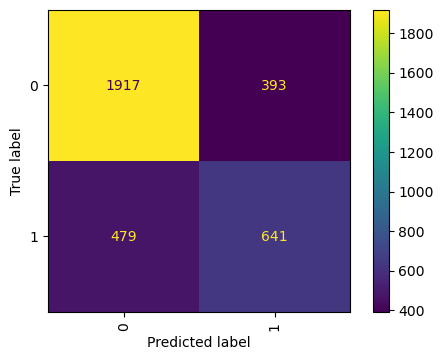

In [31]:
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(tree_model, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [32]:
import numpy as np

feature = 'Netflix'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

acc = tree_model.score(X_val, y_val)
acc_permuted = tree_model.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Title
Avengers: Infinity War               1
Spider-Man: Into the Spider-Verse    1
Django Unchained                     1
Room                                 1
Her                                  1
Name: Netflix, dtype: int64

0    2256
1    1174
Name: Netflix, dtype: int64
Validation accuracy with Netflix: 0.7457725947521866
Validation accuracy with Netflix permuted: 0.7472303206997084
Permutation importance: -0.001457725947521804


In [33]:
import numpy as np

feature = 'Netflix'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

acc = log_model.score(X_val, y_val)
acc_permuted = log_model.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Title
Avengers: Infinity War               1
Spider-Man: Into the Spider-Verse    1
Django Unchained                     1
Room                                 1
Her                                  1
Name: Netflix, dtype: int64

0    2256
1    1174
Name: Netflix, dtype: int64
Validation accuracy with Netflix: 0.5279883381924199
Validation accuracy with Netflix permuted: 0.5326530612244897
Permutation importance: -0.004664723032069884


In [34]:
y_train.head()

Title
The Matrix                        1
Back to the Future                1
The Good, the Bad and the Ugly    1
The Pianist                       1
Raiders of the Lost Ark           1
Name: Worth Watching?, dtype: int64

In [40]:
# Ignore warnings
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0507 ± 0.0092,Runtime
0.0431 ± 0.0099,Documentary
0.0160 ± 0.0062,Thriller
0.0094 ± 0.0041,Language
0.0059 ± 0.0028,Family
0.0052 ± 0.0033,Comedy
0.0040 ± 0.0023,Drama
0.0038 ± 0.0063,Directors
0.0034 ± 0.0037,Romance
0.0034 ± 0.0016,Action


In [46]:
# Model 6
model6 = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(strategy='median'),
  StandardScaler(),
  RandomForestClassifier(
      min_samples_split=4,
      max_depth=15,
      n_estimators= 200,
      n_jobs=1)
)

param_distributions = {
    'randomforestclassifier__max_depth' : (11, 12, 13, 14, 15),
    'randomforestclassifier__min_samples_split': (2, 4, 6, 8, 10),
}

search = RandomizedSearchCV(
    tree_model,
    param_distributions=param_distributions,
    n_iter=40,
    cv=7,
    scoring='accuracy',
    verbose = 30,
    return_train_score=True,
    n_jobs=4,
)

search.fit(X_train, y_train)

print('Cross-validation Best Score:', search.best_score_)
print('Best Estimator:', search.best_params_)
print('Best Model:', search.best_estimator_)

/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.9s


ValueError: Invalid parameter randomforestclassifier for estimator Pipeline(steps=[('oe',
                 OrdinalEncoder(cols=['Age', 'Directors', 'Country', 'Language',
                                      'Action', 'Adventure', 'Animation',
                                      'Biography', 'Comedy', 'Crime',
                                      'Documentary', 'Drama', 'Family',
                                      'Fantasy', 'Film Noir', 'History',
                                      'Horror', 'Music', 'Musical', 'Mystery',
                                      'Romance', 'Sci-Fi', 'Short Film',
                                      'Sport', 'Superhero', 'Thriller', 'War',
                                      'Western'],
                                mapping=[{'col': 'Age', 'data_...
                                         {'col': 'Superhero',
                                          'data_type': dtype('O'),
                                          'mapping': 0.0    1
NaN   -2
dtype: int64},
                                         {'col': 'Thriller',
                                          'data_type': dtype('O'),
                                          'mapping': 0.0    1
1.0    2
NaN   -2
dtype: int64},
                                         {'col': 'War', 'data_type': dtype('O'),
                                          'mapping': 0.0    1
1.0    2
NaN   -2
dtype: int64},
                                         {'col': 'Western',
                                          'data_type': dtype('O'),
                                          'mapping': 0.0    1
1.0    2
NaN   -2
dtype: int64}])),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [44]:
Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Age', 'Directors', 'Country', 'Language',
                                     'Action', 'Adventure', 'Animation',
                                     'Biography', 'Comedy', 'Crime',
                                     'Documentary', 'Drama', 'Family',
                                     'Fantasy', 'Film Noir', 'History',
                                     'Horror', 'Music', 'Musical', 'Mystery',
                                     'Romance', 'Sci-Fi', 'Short Film', 'Sport',
                                     'Superhero', 'Thriller', 'War',
                                     'Western'])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=15,
                                        n_estimators=149, random_state=42))])

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Age', 'Directors', 'Country', 'Language',
                                     'Action', 'Adventure', 'Animation',
                                     'Biography', 'Comedy', 'Crime',
                                     'Documentary', 'Drama', 'Family',
                                     'Fantasy', 'Film Noir', 'History',
                                     'Horror', 'Music', 'Musical', 'Mystery',
                                     'Romance', 'Sci-Fi', 'Short Film', 'Sport',
                                     'Superhero', 'Thriller', 'War',
                                     'Western'])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=15,
                                        n_estimators=149, random_state=42))])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

model7 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
      StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': 15, 
    'randomforestregressor__max_depth': 14, 
    'randomforestregressor__max_features': 0.3763983510221083, 
}

search.fit(X_train, y_train);

print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

In [ ]:
search.best_estimator_

In [ ]:
# Partial Dependence Plot
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

# Partial Dependence Plot

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
X_val.isnull().sum()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Year'

isolated = pdp_isolate(
    model=tree_model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Runtime', 'Year']

interaction = pdp_interact(
    model=tree_model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
row = X_val.iloc[[0]]
row

In [ ]:
y_val.iloc[[0]]

In [ ]:
model3.predict(row)

In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)